In [59]:
import geopandas as gpd
import pandas as pd
from rasterio.enums import Resampling
import xarray as xr

In [2]:
quantitative = xr.open_zarr("/shares/iborlafm/home/20250729-DrySat/data/harmonised-vegetation-300m.zarr", consolidated=False)
quantitative.rio.write_crs("EPSG:4326", inplace=True);

In [3]:
quantitative.rio.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [4]:
qualitative = (
    xr.open_dataset("/home/iborlafm/Downloads/Mozambique/Hansen/Hansen_GFC-2024-v1.12_lossyear_Gorongosa_gte2015.tif", mask_and_scale=False)
    .sel(band=1)["band_data"].drop_vars("band")
    #.rename({"y": "lat", "x": "lon"})
    )

In [5]:
spatial_ref = quantitative["spatial_ref"].attrs

In [28]:
deforested_pixels = (
    qualitative.rio.reproject_match(quantitative, resampling=Resampling.sum)
    .rename("deforested_pixels")
    )

In [65]:
most_deforested = (
    deforested_pixels.drop_vars("spatial_ref").to_dataframe().reset_index()
    .sort_values("deforested_pixels", ascending=False, ignore_index=True)
    .head(10)
    )

most_deforested = gpd.GeoDataFrame(
    most_deforested,#[["deforested_pixels"]],
    geometry=gpd.points_from_xy(
        x=most_deforested["x"],
        y=most_deforested["y"],
        crs=quantitative.rio.crs
        ),
    crs=quantitative.rio.crs
)

In [ ]:
quantitative

In [66]:
most_deforested

,y,x,deforested_pixels,geometry
0,-18.818452,34.017857,142,POINT (34.01786 -18.81845)
1,-18.848214,34.038690,142,POINT (34.03869 -18.84821)
2,-18.845238,34.029762,142,POINT (34.02976 -18.84524)
3,-18.845238,34.032738,142,POINT (34.03274 -18.84524)
4,-18.845238,34.038690,140,POINT (34.03869 -18.84524)
5,-18.889881,34.062500,140,POINT (34.0625 -18.88988)
6,-18.848214,34.035714,140,POINT (34.03571 -18.84821)
7,-18.839286,34.035714,139,POINT (34.03571 -18.83929)
8,-18.815476,34.017857,139,POINT (34.01786 -18.81548)
9,-18.845238,34.035714,138,POINT (34.03571 -18.84524)


In [64]:
most_deforested.to_file("/home/iborlafm/Downloads/Mozambique/Hansen/Hansen_GFC-2024-v1.12_most_Gorongosa_gte2015.geojson")

In [39]:
lat_max, lon_max = most_deforested.loc[0, ["y", "x"]]

In [32]:
max_idx

{'y': 56, 'x': 23}

In [43]:
timeline = (
    quantitative.sel(lat=lat_max, lon=lon_max)
    .drop_vars(["spatial_ref", "crs"]) #, "lat", "lon"
    .to_dataframe()
    .dropna()
    .reset_index()
    )

In [54]:
dates = (
    timeline["year"].astype(str) +
    timeline["month"].astype(str).str.zfill(2) +
    "15"
    )

timeline["date"] = pd.to_datetime(dates, format=r"%Y%m%d")

<Axes: xlabel='date'>

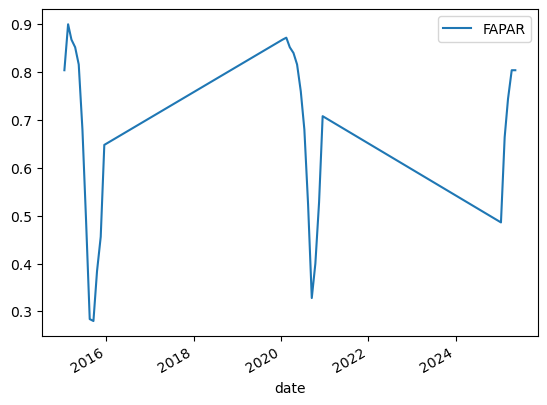

In [57]:
timeline.plot(x="date", y="FAPAR")